
Language Translation
===================================



### Install the required packages

In [ ]:
# !python -m spacy download en
# !python -m spacy download de
# !pip3 install torchtext --upgrade
# !pip install -U sacremoses

### Connect to the google drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
import sys

In [ ]:

path = '/content/gdrive/My Drive/NLP/project/'
os.chdir(path)
print(os.getcwd())

/content/gdrive/My Drive/NLP/project


In [ ]:
%matplotlib inline

Data Processing
----------------




In [ ]:
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
import io

In [ ]:


train_filepaths = ['./small_datasets/train.en', './small_datasets/train.hi']
val_filepaths = ['./dev_test/dev.en', './dev_test/dev.hi']
test_filepaths = ['./dev_test/test.en', './dev_test/test.hi']


In [ ]:
train_filepaths

['./small_datasets/train.en', './small_datasets/train.hi']

In [ ]:

hi_tokenizer = get_tokenizer('moses', 'hi')
en_tokenizer = get_tokenizer('spacy', language='en')

def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

en_vocab = build_vocab(train_filepaths[0], en_tokenizer)
hi_vocab = build_vocab(train_filepaths[1], hi_tokenizer)

def data_process(filepaths):
  raw_en_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_de_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                            dtype=torch.long)
    de_tensor_ = torch.tensor([hi_vocab[token] for token in hi_tokenizer(raw_de)],
                            dtype=torch.long)
    data.append((en_tensor_, de_tensor_))
  return data

train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

In [ ]:
# len(train_data)
print(train_data[0:1])

[(tensor([3245,   43,  304,   45, 1966, 8078,    4]), tensor([ 412,  305,    4,   86,   20, 2363,   93,    4, 7538,   29, 7116,  306]))]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device )

cuda


``DataLoader``
----------------





In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 16
PAD_IDX = hi_vocab['<pad>']
BOS_IDX = hi_vocab['<bos>']
EOS_IDX = hi_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return de_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [ ]:
train_iter

Defining our ``Model`` and ``Optimizer``
----------------





In [ ]:
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
import math
import time


In [ ]:

class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,
                src: Tensor) -> Tuple[Tensor]:

        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden


class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim

        self.attn = nn.Linear(self.attn_in, attn_dim)

    def forward(self,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tensor:

        src_len = encoder_outputs.shape[0]

        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))

        attention = torch.sum(energy, dim=2)

        return F.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: int,
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def _weighted_encoder_rep(self,
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor) -> Tensor:

        a = self.attention(decoder_hidden, encoder_outputs)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        return weighted_encoder_rep


    def forward(self,
                input: Tensor,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tuple[Tensor]:

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)

        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)

        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)

        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim = 1))

        return output, decoder_hidden.squeeze(0)



In [ ]:

class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device: torch.device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self,
                src: Tensor,
                trg: Tensor,
                teacher_forcing_ratio: float = 0.5) -> Tensor:

        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        # first input to the decoder is the <sos> token
        output = trg[0,:]

        for t in range(1, max_len):
            output, hidden = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)

        return outputs


### Hyper-parameters 

In [ ]:

INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(hi_vocab)
# ENC_EMB_DIM = 256
# DEC_EMB_DIM = 256
# ENC_HID_DIM = 512
# DEC_HID_DIM = 512
# ATTN_DIM = 64
# ENC_DROPOUT = 0.5
# DEC_DROPOUT = 0.5

ENC_EMB_DIM = 32
DEC_EMB_DIM = 32
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
LEARNING_RATE = 0.001


#### Initialize the model and optimizer

In [ ]:




enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)


def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


# model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)


def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,239,402 trainable parameters


Note: when scoring the performance of a language translation model in
particular, we have to tell the ``nn.CrossEntropyLoss`` function to
ignore the indices where the target is simply padding.



In [ ]:
PAD_IDX = hi_vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

Finally, we can train and evaluate this model:



In [ ]:


def train(model: nn.Module,
          iterator: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0
    epoch_bleu = 0.0 

    for _, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        sent_bleu_score = 0.0

    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: torch.utils.data.DataLoader,
             criterion: nn.Module):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for _, (src, trg) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



In [ ]:
import json
from collections import defaultdict

In [ ]:
TRAIN_LOADED_MODEL = False

In [ ]:
SAVE_PATH = './saved_model/torchtext_eng_hin_model_best.tar'

### Reload the model if it's already trained from the previous checkpoint

In [ ]:

## Important to do the following step to freeze the layers and use the model for evaluation
# encoder_loaded.eval()
# attn_decoder_loaded.eval()

##  Load the dictionary from saved file
checkpoint = torch.load(SAVE_PATH)

# load the state from dictionary 
model.load_state_dict(checkpoint['model'])

if TRAIN_LOADED_MODEL:
  model.train()
else: 
  model.eval()

model = model.to(device)

### Train the model

In [ ]:
RUN_NUM = 2

In [ ]:

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

train_loss_list = []
valid_loss_list = []
valid_bleu_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)

    bleu_score = bleu(val_data, model, en_vocab=en_vocab, hi_vocab=hi_vocab , device = device)

    end_time = time.time()
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    valid_bleu_list.append(bleu_score)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    if valid_loss <= best_valid_loss:
        best_valid_loss = valid_loss
        print('saving best model !!!!')
        torch.save( { 'model' : model.state_dict() } , './saved_model/torchtext_eng_hin_model_best.tar')    

training_history = {'train_loss' : train_loss_list, 
                    'valid_loss' : valid_loss_list, 
                    'valid_bleu' : valid_bleu_list }

torch.save( { 'model' : model.state_dict() } , SAVE_PATH )

json.dump(training_history , open(f'./seq2seq_results_50/torchtext_history_dict_run{RUN_NUM}.json', 'w'))

Epoch: 01 | Time: 31m 59s
	Train Loss: 1.735 | Train PPL:   5.672
	 Val. Loss: 9.741 |  Val. PPL: 16997.513
saving best model !!!!
Epoch: 02 | Time: 32m 13s
	Train Loss: 1.661 | Train PPL:   5.263
	 Val. Loss: 9.874 |  Val. PPL: 19418.645
Epoch: 03 | Time: 32m 8s
	Train Loss: 1.602 | Train PPL:   4.961
	 Val. Loss: 10.055 |  Val. PPL: 23266.586
Epoch: 04 | Time: 32m 17s
	Train Loss: 1.554 | Train PPL:   4.729
	 Val. Loss: 10.430 |  Val. PPL: 33847.778
Epoch: 05 | Time: 32m 22s
	Train Loss: 1.517 | Train PPL:   4.559
	 Val. Loss: 10.150 |  Val. PPL: 25596.756
Epoch: 06 | Time: 31m 46s
	Train Loss: 1.481 | Train PPL:   4.397
	 Val. Loss: 10.523 |  Val. PPL: 37171.969
Epoch: 07 | Time: 30m 54s
	Train Loss: 1.453 | Train PPL:   4.276
	 Val. Loss: 10.491 |  Val. PPL: 35990.215
Epoch: 08 | Time: 30m 43s
	Train Loss: 1.427 | Train PPL:   4.166
	 Val. Loss: 10.253 |  Val. PPL: 28366.083
Epoch: 09 | Time: 30m 48s
	Train Loss: 1.403 | Train PPL:   4.069
	 Val. Loss: 10.359 |  Val. PPL: 31539.722

### Plot the results

In [ ]:
### Accumulate training history from all the runs 

plot_training_history = defaultdict(list)
# train_loss_list = []
# val_loss_list = []
# train_bleu_list= []
# val_bleu_list = []


for i in range(1, RUN_NUM +1 ):
    history_temp = json.load( open( f'./seq2seq_results_50/torchtext_history_dict_run{i}.json', 'r' ) )
    # train_loss_list.extend(history_temp['train_loss'])
    # val_loss_list.extend(history_temp['val_loss'])
    # train_bleu_list.extend(history_temp['train_bleu_score'])
    # val_bleu_list.extend(history_temp['val_bleu_score'])
    plot_training_history['train_loss'].extend(history_temp['train_loss'])
    plot_training_history['valid_loss'].extend(history_temp['valid_loss'])
    # plot_training_history['train_bleu_score'].extend(history_temp['train_bleu_score'])
    plot_training_history['valid_bleu'].extend(history_temp['valid_bleu'])
    
print(plot_training_history)

training_history = plot_training_history

defaultdict(<class 'list'>, {'train_loss': [3.967259504404068, 2.7132083394527435, 2.221542568244934, 1.9824558515596389, 1.8381021173667909, 1.7354991507101059, 1.6607201143622399, 1.601632894706726, 1.5537706855988502, 1.5170962100338936, 1.4809925798916816, 1.4530559093213082, 1.4270565315580368, 1.4034956096673012, 1.3854868624949455], 'valid_loss': [9.455787687590629, 9.232910531939883, 9.347201520746404, 9.95346196492513, 9.98862194292473, 9.740822300766453, 9.8739889607285, 10.05477353298303, 10.429628632285379, 10.150220899870902, 10.523310227827592, 10.491002371816924, 10.252949454567649, 10.359003038117379, 10.280921184655393], 'valid_bleu': [0.19685596213793444, 0.1905893543261991, 0.19846635639835705, 0.1973236611954377, 0.18714127080199097, 0.18441465800150803, 0.19264764247165803, 0.17904286407769152, 0.19758561711081626, 0.19036256311286764, 0.19380237651124152, 0.1943975532967876, 0.18962087490120497, 0.19401063477881364, 0.1856276820414303]})


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

<Figure size 432x288 with 0 Axes>

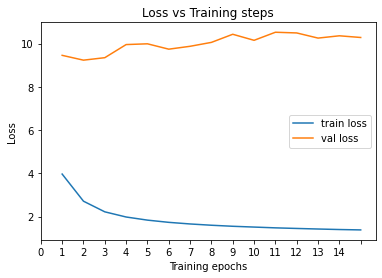

In [ ]:
## PLot the train and validation loss 
plt.figure()
fig, ax = plt.subplots()
plt.plot(training_history['train_loss'], label = 'train loss')
plt.plot(training_history['valid_loss'], label = 'val loss')
plt.xticks(ticks= np.arange(-1, 15), labels=np.arange(0,15))
plt.title('Loss vs Training steps')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'./seq2seq_results_50/torchtext_loss_plot_run_all.png')
plt.show()

<Figure size 432x288 with 0 Axes>

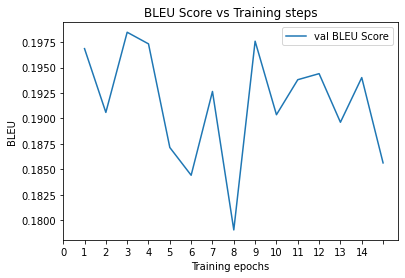

In [ ]:
## PLot the train and validation bleu score
plt.figure()
fig, ax = plt.subplots()
# plt.plot(training_history['train_bleu_score'], label = 'train BLEU Score')
plt.plot(training_history['valid_bleu'], label = 'val BLEU Score')
plt.xticks(ticks= np.arange(-1, 15), labels=np.arange(0,15))
plt.title('BLEU Score vs Training steps')
plt.xlabel('Training epochs')
plt.ylabel('BLEU')
plt.legend()
plt.savefig(f'./seq2seq_results_50/torchtext_bleu_plot_run_all.png')
plt.show()

### On Test data

In [ ]:
import torch
import spacy
from torchtext.data.metrics import bleu_score
import sys

In [ ]:
def translate_sentence(model, sentence, en_vocab, hi_vocab, device, max_length=50):
    # Load german tokenizer
    # spacy_ger = spacy.load("de")
    

    # Create tokens using spacy and everything in lower case (which is what our vocab is)
    if type(sentence) == str:
        tokens = [token.text.lower() for token in en_tokenizer(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, en_vocab.stoi['<bos>'] )
    tokens.append(en_vocab.stoi['<eos>'])

    # Go through each german token and convert to an index
    text_to_indices = [en_vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    outputs = [hi_vocab.stoi["<bos>"]]
    for i in range(max_length):
        trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)

        with torch.no_grad():
            output = model(sentence_tensor, trg_tensor)

        best_guess = output.argmax(2)[-1, :].item()
        outputs.append(best_guess)

        if best_guess == hi_vocab.stoi["<eos>"]:
            break

    translated_sentence = [hi_vocab.itos[idx] for idx in outputs]
    # remove start token
    return translated_sentence[1:]

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction 
import numpy as np

In [ ]:
def bleu(data, model, en_vocab, hi_vocab, device):
    targets = []
    outputs = []
    bleu_scores_list = []
    
    for example in data:
        # print(len(example))
        # src = vars(example)["src"]
        # trg = vars(example)["trg"]
        src = [en_vocab.itos[idx] for idx in example[0]]
        trg = [hi_vocab.itos[idx] for idx in example[1]]

        prediction = translate_sentence(model, src, en_vocab, hi_vocab, device)
        prediction = prediction[:-1]  # remove <eos> token
        targets.append([trg])
        outputs.append(prediction)
        

        actual_sent_splitted = trg
        output_sent_splitted = prediction

        smoothing_function = SmoothingFunction().method4
        sent_bleu_score = 0.0

        try:
            sent_bleu_score = sentence_bleu(references = [actual_sent_splitted] ,  
                                    hypothesis = output_sent_splitted , 
                                    weights = (0.25, 0.25, 0.25, 0.25),
                                    smoothing_function =  smoothing_function )
        except:
            pass
        
        bleu_scores_list.append(sent_bleu_score)
    

    avg_bleu_score = np.nanmean(bleu_scores_list)

    return avg_bleu_score
    # return bleu_score(outputs, targets)

In [ ]:
# running on entire test data takes a while
score1 = bleu(test_data[:1200], model, en_vocab=en_vocab, hi_vocab=hi_vocab , device = device)


In [ ]:
score2 = bleu(test_data[1200:], model, en_vocab=en_vocab, hi_vocab=hi_vocab , device = device)



In [ ]:
score = (score1 + score2)/2.0
print(f"Bleu score using the best checkpoint model : {score * 100:.4f}")

Bleu score using the best checkpoint model : 17.2920


In [ ]:
score = (score1 + score2)/2.0
print(f"Bleu score using the last checkpoint model : {score * 100:.4f}")

Bleu score using the last checkpoint model : 17.8334


### Translate the actual sentence

- Here, I am using the sentence from the test data

In [ ]:
# translated_sentence = translate_sentence(model = model, sentence = INFERENCE_SENTENCE, en_vocab, hi_vocab, device, max_length=50)

In [ ]:
from sacremoses.tokenize import MosesDetokenizer

In [ ]:
hi_detokenizer = MosesDetokenizer(lang = 'hi')

In [ ]:
def translate_sentences(data, model, en_vocab, hi_vocab, device):
    bleu_scores_list = []
    
    for example in data:
        src = [en_vocab.itos[idx] for idx in example[0]]
        trg = [hi_vocab.itos[idx] for idx in example[1]]

        prediction = translate_sentence(model, src, en_vocab, hi_vocab, device)
        prediction = prediction[:-1]  # remove <eos> token
        
        # en_tok

        actual_sent_splitted = trg
        output_sent_splitted = prediction
        
        
        detokenized_src = ' '.join(src)
        detokenized_trg = hi_detokenizer.detokenize(tokens=trg, return_str = True)
        detokenized_pred_trg = hi_detokenizer.detokenize(tokens=prediction, return_str = True)

        print("Source input sentence: ")
        print(detokenized_src)
        print("Target output sentence: ")
        print(detokenized_trg)

        print("Predicted Target output sentence: ")
        print(detokenized_pred_trg)
        
        smoothing_function = SmoothingFunction().method4
        sent_bleu_score = 0.0

        try:
            sent_bleu_score = sentence_bleu(references = [actual_sent_splitted] ,  
                                    hypothesis = output_sent_splitted , 
                                    weights = (0.25, 0.25, 0.25, 0.25),
                                    smoothing_function =  smoothing_function )
        except:
            pass
        print("This sentence bleu is : " , sent_bleu_score)
        print(' ')
        bleu_scores_list.append(sent_bleu_score)
    

    avg_bleu_score = np.nanmean(bleu_scores_list)
    
    return avg_bleu_score

In [ ]:
blue_translate = translate_sentences(data = test_data[20:25], model = model , en_vocab = en_vocab, hi_vocab = hi_vocab, device = device)

Source input sentence: 
His state recently put tracking devices on 500 <unk> to test out a pay - by - mile system . 

Target output sentence: 
उनके राज ् य ने प ् <unk> भुगतान प ् रणाली का परीक ् षण करने के लिए हाल ही में 500 कारों में ट ् रैकिंग डिवाइस लगाई है ।
Predicted Target output sentence: 
<unk> आपकी खोज स स ् थिति थिति में. ् ् ् रीन ् को को ् ् से ् रीन होता सेवर को. "के के ् ् वारा द को ्" ् "लिए के से ् ्
This sentence bleu is :  0.28098810811880787
 
Source input sentence: 
" This works out as the most logical alternative over the long term , " he said . 

Target output sentence: 
वे कहते हैं, "दीर ् <unk> में यह सबसे अधिक तर ् <unk> ् ण विकल ् प के रूप में काम करेगा ।"
Predicted Target output sentence: 
<unk> इस भी भी भी भी भी भी भी भी हो हो,,, ",,",, ",," "के द द भी वारा हल हल कर कर रहे रहे हैं,," के के द भी ् वारा वारा भी
This sentence bleu is :  0.14340555326583423
 
Source input sentence: 
<unk> call it a <unk> - based user fee . 

Target output sentence: 
<unk> ् क ्

### Reference :

- https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html 

- modified the part for training, validation, testing

- Added the code for plotting the results

- Added the code for translation

- Added saving and reloading part

- Modified the tokenizers (Spacy and Moses) and vocabularies